In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys
import pathlib

In [5]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import the local package 

In [6]:
sys.path.append('../../')

In [7]:
import numpy as np 

In [8]:
from ICU_Water_Watch import plot, utils, GPM, geo

### first step, we update the local GPM-IMERG dataset on disk, which is in by default `/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP`

In [9]:
GPM.update(lag=1)

Last downloaded file in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP is GPM_IMERG_daily.v06.2021.10.09.nc

trying to download GPM_IMERG_daily.v06.2021.10.10.nc in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP

! file size for input file 3B-DAY-L.MS.MRG.3IMERG.20211010-S000000-E235959.V06.nc4 is too small, netcdf file GPM_IMERG_daily.v06.2021.10.10.nc is not yet available to download from https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDL.06/2021/10



In [15]:
ndays = 90

In [16]:
dpath_realtime = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP'

In [17]:
lfiles = GPM.get_files_list(dpath = dpath_realtime, ndays=ndays, lag=2)

In [18]:
dset = GPM.make_dataset(lfiles, ndays=ndays)

In [19]:
dset.dims

Frozen({'time': 90, 'lat': 300, 'lon': 460})

In [20]:
dset.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the last date and the number of days in the dataset, which are created automatically as global attributes in the dataset 

In [21]:
last_date, ndays_dset  = GPM.get_attrs(dset)

In [22]:
last_date

datetime.datetime(2021, 10, 8, 0, 0)

In [23]:
ndays_dset

90

### extract a "virtual station" from the dataset 

#### we choose Afulilo Dam (Samoa) as an example 

In [25]:
station_name = 'Afulilo Dam'
lon = 171.5621
lat = -13.9708

#### the function also returns the extracted coordinates, and the distance to the actual coordinates passed, in km 

In [26]:
df, extracted_coords, dist = GPM.get_virtual_station(dset, lat=lat, lon=lon)

In [27]:
df.head()

,observed
2021-07-11,4.513861
2021-07-12,0.935294
2021-07-13,0.020537
2021-07-14,0.636999
2021-07-15,0.233706


In [28]:
extracted_coords

(171.625, -13.875)

In [29]:
dist

12.651426693670807

#### we now extract the daily climatology (default file name is `daily_climatology_5days_rm_2001_2020.nc`, calculated in `notebooks/GPM/calculates_GPM-IMERG_daily_climatologies.ipynb`)

In [30]:
dpath_climatology = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP/CLIMATOLOGY'

In [31]:
clim = GPM.get_virtual_station_climatology(dpath=dpath_climatology, lat=lat, lon=lon)

In [32]:
df = GPM.join_clim(df, clim)

In [33]:
df.head()

,observed,climatology
2021-07-11,4.513861,2.351376
2021-07-12,0.935294,2.607127
2021-07-13,0.020537,2.602752
2021-07-14,0.636999,4.535330
2021-07-15,0.233706,4.756341


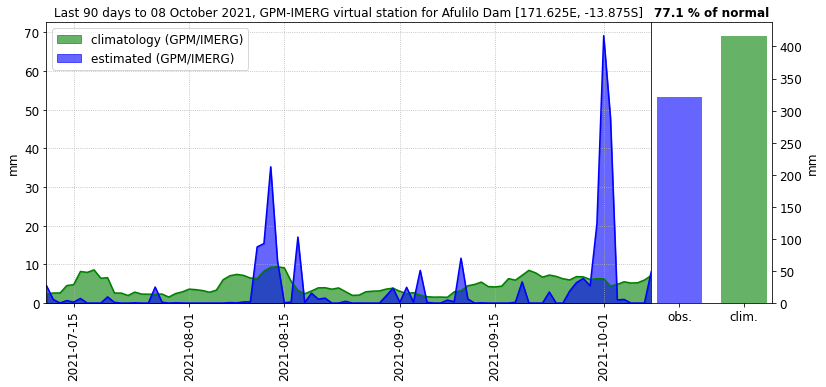

In [34]:
f = plot.plot_virtual_station(df, station_name=station_name, lon=extracted_coords[0], lat=extracted_coords[-1])

### calculate the rainfall accumulation over the past N days 

In [35]:
dset_accum = GPM.calculate_realtime_accumulation(dset)

In [36]:
dset_accum.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [37]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 335.7 337.1 338.7 ... 10.83 18.44

### get the rain days stats: number of rain days (threshold = 1 mm/day), number of dry days, and number of days since last rain

In [38]:
dset_ndays = GPM.get_rain_days_stats(dset)

In [39]:
dset_ndays.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [40]:
dset_ndays.data_vars

Data variables:
    wet_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    dry_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    days_since_rain  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the climatology, for the calculation of the anomalies 

In [41]:
clim = GPM.get_climatology(dpath=dpath_realtime, ndays=ndays, date=last_date)

### calculates the anomalies and the percentages of scores, and insert the resulting variables (`anoms` and `pctscore`) in the dataset 

In [42]:
dset_accum = GPM.calc_anoms_and_pctscores(dset_accum, clim)

In [43]:
dset_accum.dims

Frozen({'time': 1, 'lat': 300, 'lon': 460})

In [44]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 335.7 337.1 338.7 ... 10.83 18.44
    pctscore          (time, lat, lon) float64 67.0 61.0 65.0 ... 15.0 11.0 25.0
    anoms             (time, lat, lon) float64 21.89 21.52 ... -28.55 -22.05

### get the EEZs for each country, and a dissolved version for the mask 

In [45]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### insert the mask in each dataset 

In [46]:
dset_accum = geo.make_mask_from_gpd(dset_accum, merged_EEZs, subset=True, mask_name='EEZ')

In [47]:
dset_ndays = geo.make_mask_from_gpd(dset_ndays, merged_EEZs, subset=True, mask_name='EEZ')

### plots the precipitation accumulation 

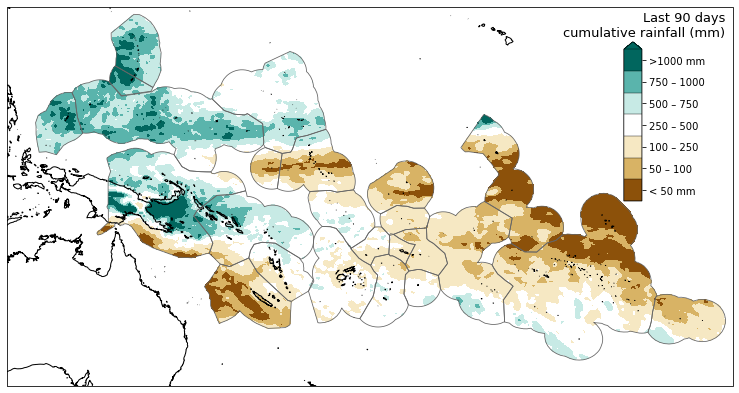

In [48]:
plot.map_precip_accum(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='.')

### Plots the precipitation anomalies 

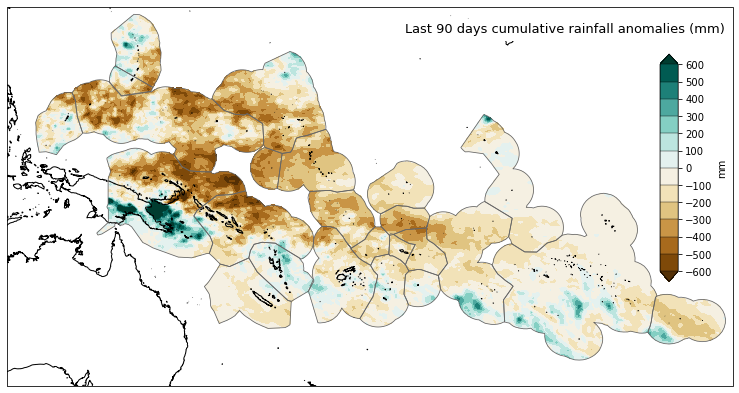

In [49]:
plot.map_precip_anoms(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='.')

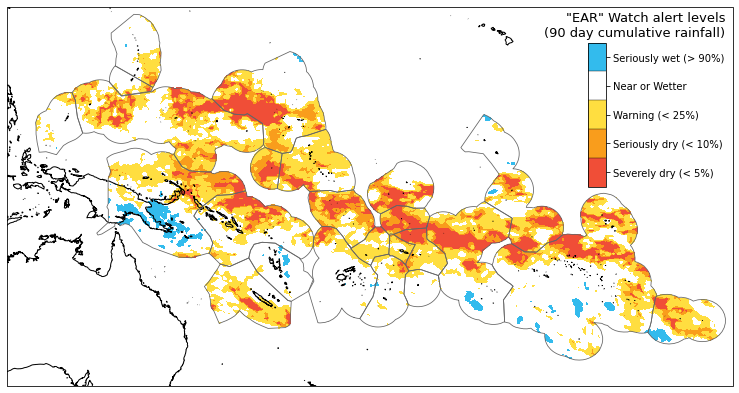

In [50]:
plot.map_EAR_Watch_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

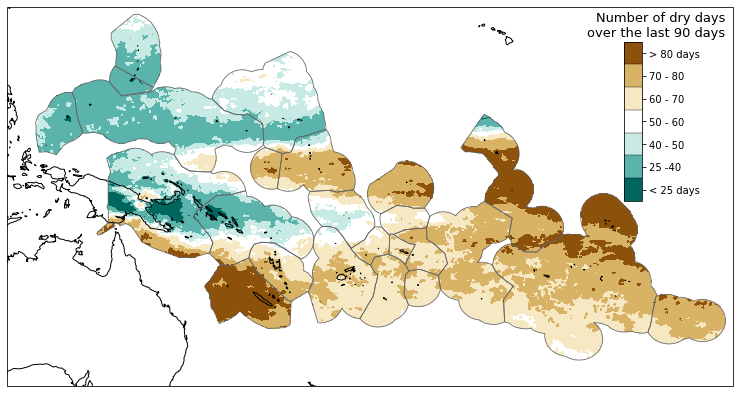

In [51]:
plot.map_dry_days_Pacific(dset_ndays, mask='EEZ', geoms=EEZs, close=False, fpath='.')

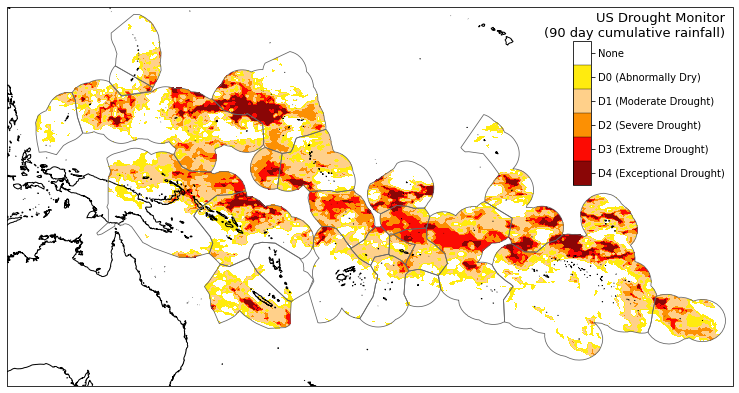

In [52]:
plot.map_USDM_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

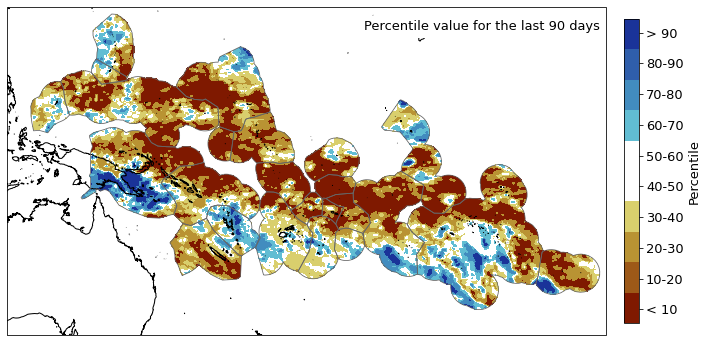

In [53]:
plot.map_decile(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

### creates on dataset per country, including the EEZ mask, which then could be exported if needed 

In [54]:
for i, country_name in enumerate(EEZs.COUNTRYNAM): 
    c = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    sub = geo.make_mask_from_gpd(dset_accum, c, mask_name='mask_EEZ')

In [55]:
country_name

'French Polynesia'

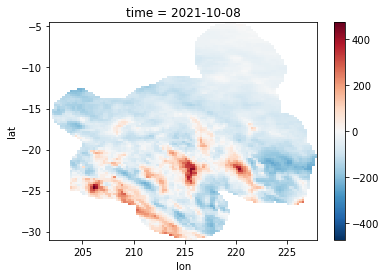

In [56]:
(sub['anoms'] * sub['mask_EEZ']).squeeze().plot()